# Very Simple Demonstration

Here is the NCE VAE being run on a bunch of PBMC data. The tabula sapiens dataset can be downloaded by running the following:

```{bash}
!wget https://datasets.cellxgene.cziscience.com/4eb58518-23ce-43e8-89ca-9e9fa87c081d.h5ad -O tabula-sapiens-blood.h5ad
```

In [3]:
!pip uninstall ncvae -y
!pip install git+https://github.com/jhaberbe/nce-vae

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jhaberbe/nce-vae to /tmp/pip-req-build-3b7mynyj
  Running command git clone --filter=blob:none --quiet https://github.com/jhaberbe/nce-vae /tmp/pip-req-build-3b7mynyj
  Resolved https://github.com/jhaberbe/nce-vae to commit 7690d6a8d7fb19ba2842a5b7e6f5092644ee87a7
  Preparing metadata (setup.py) ... done
  Created wheel for ncvae: filename=ncvae-0.1.0-py3-none-any.whl size=24147 sha256=36bac71a767e8e5d23d55c28ec42644b397c6b7f57586135c4d248ad6a255c4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-uxv9o6ca/wheels/98/b6/8f/205d3e0005ae00ee56418ecb6ecaf5b21f63ce72db31bfef1a
Successfully built ncvae

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
import ncvae
import pandas as pd
import scanpy as sc

adata = sc.read_h5ad("tabula-sapiens-blood.h5ad")
X = torch.tensor(adata.raw.X.todense()).float()
X_batch = torch.tensor(pd.get_dummies(adata.obs["sample_id"]).astype(float).values).float()

We setup the model. 

Make sure to specify the same number of latent dimensions for the NCVAE as the input dimensions of the NCVAE Discriminator. I've set it to 64 by default, which should be fine for the most part.

In [5]:
vae = ncvae.model.NCVAE(input_dim=X.shape[1], batch_dim = X_batch.shape[1])
discriminator = ncvae.model.NCVAEDiscriminator()

# Training

Very quick on GPU, but acceptable on CPU for moderate sized datasets. On GPU I was able to train it in 3 minutes (I manually canceled training once it converged, which is why there are error messages below). 

To others, there may be a few defaults that are annoying. 

- Logging to WanDB by default.
- Hardcoded batch-sizes
- Hardcoded epochs

I'll update those in the future, but those are QoL updates, the main package works well. 

On this dataset, all the different losses will converge in about 300, but I think that the longer you 'burn in', the higher quality that you get in the representation, even if it isn't obvious from the training loss.

In [7]:
ncvae.train.train_nc_vae(
    X.float(),
    X_batch.float(),
    vae,
    discriminator,
    wandb_project = "nce-vae-batched",
    wandb_name = "ice-fairy"
)

KeyboardInterrupt: 

# Latent Representation 

I perform minibatching here to ensure that I don't run out of memory. I'll include this function in the package in the future.

In [8]:
from tqdm import tqdm
import torch

def forward_minibatch(model, X, batch_size=128, device="cuda"):
    """
    Forward passes X through the model in minibatches and returns the concatenated result.
    
    Args:
        model (torch.nn.Module): The model to evaluate.
        X (torch.Tensor): Input tensor of shape (N, ...).
        batch_size (int): Size of minibatches.
        device (torch.device or str, optional): If given, moves X to this device during processing.

    Returns:
        torch.Tensor: Concatenated model outputs for all of X.
    """
    model.eval()  # Set model to eval mode
    outputs = []
    
    if device is None:
        device = next(model.parameters()).device
    else:
        device = torch.device(device)

    with torch.no_grad():
        for start_idx in tqdm(range(0, len(X), batch_size)):
            end_idx = start_idx + batch_size
            batch = X[start_idx:end_idx].to(device)
            out = vae.message_sender.get_latent_representation(batch)
            outputs.append(out.cpu())  # Collect on CPU to avoid memory overflow

    return torch.cat(outputs, dim=0).detach().numpy()


adata.obsm["X_ncVAE"] = forward_minibatch(vae, X)

100%|██████████| 666/666 [00:04<00:00, 144.89it/s]


# Comparison of Latent Representation

I'm going to compare UMAP and cell types generated in the publication to those generated using this VAE. The ideal output would be:

- Similar cell type separation.
- Distinguished cell types.
- Batch effects should be minimal.

The default cell typing works well. Broad cell classes are well distinguished. 

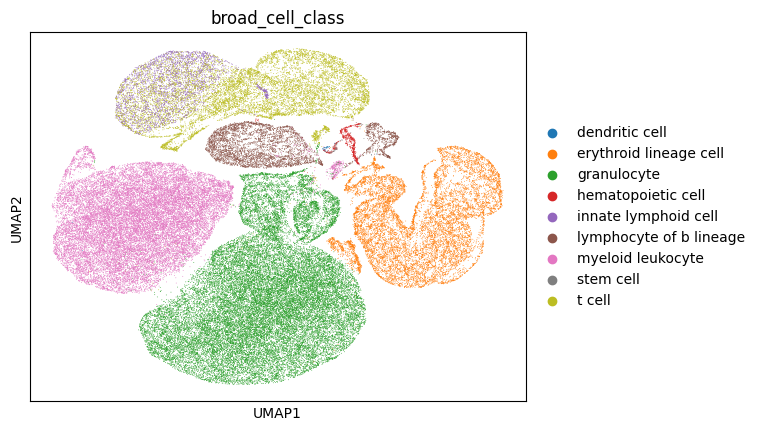

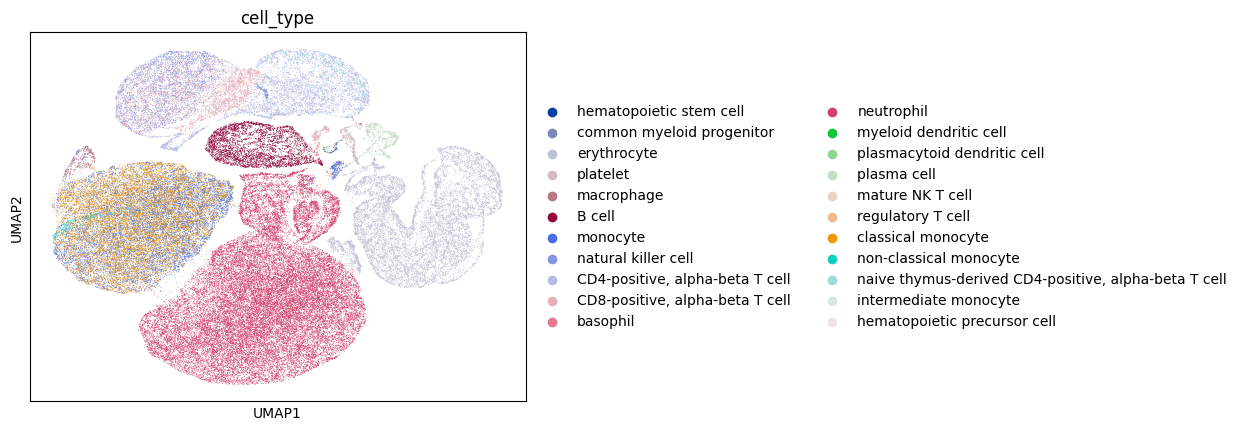

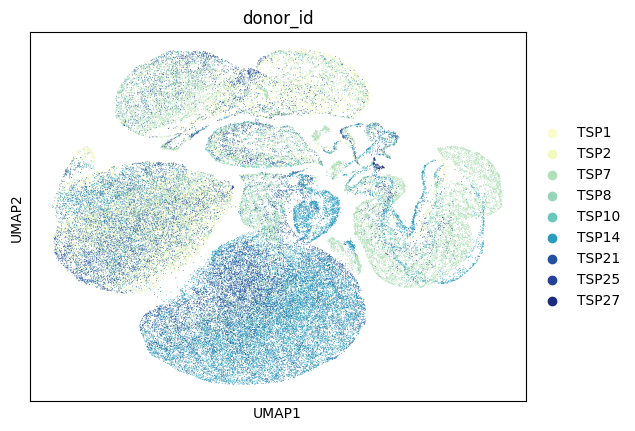

In [9]:
sc.pl.umap(adata, color=["broad_cell_class"])
sc.pl.umap(adata, color=["cell_type"])
sc.pl.umap(adata, color=["donor_id"])

We can also see that they've done pretty good at reducing batch effects, but there are definitely some samples with more of a particular cell type than another. At worst, our NCE-VAE should never exacerbate this, at best we should see some improvement where relevant cell types can be merged.

/tmp/ipykernel_105343/4284702736.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts = adata.obs.pivot_table(index="donor_id", columns="broad_cell_class", aggfunc="size")


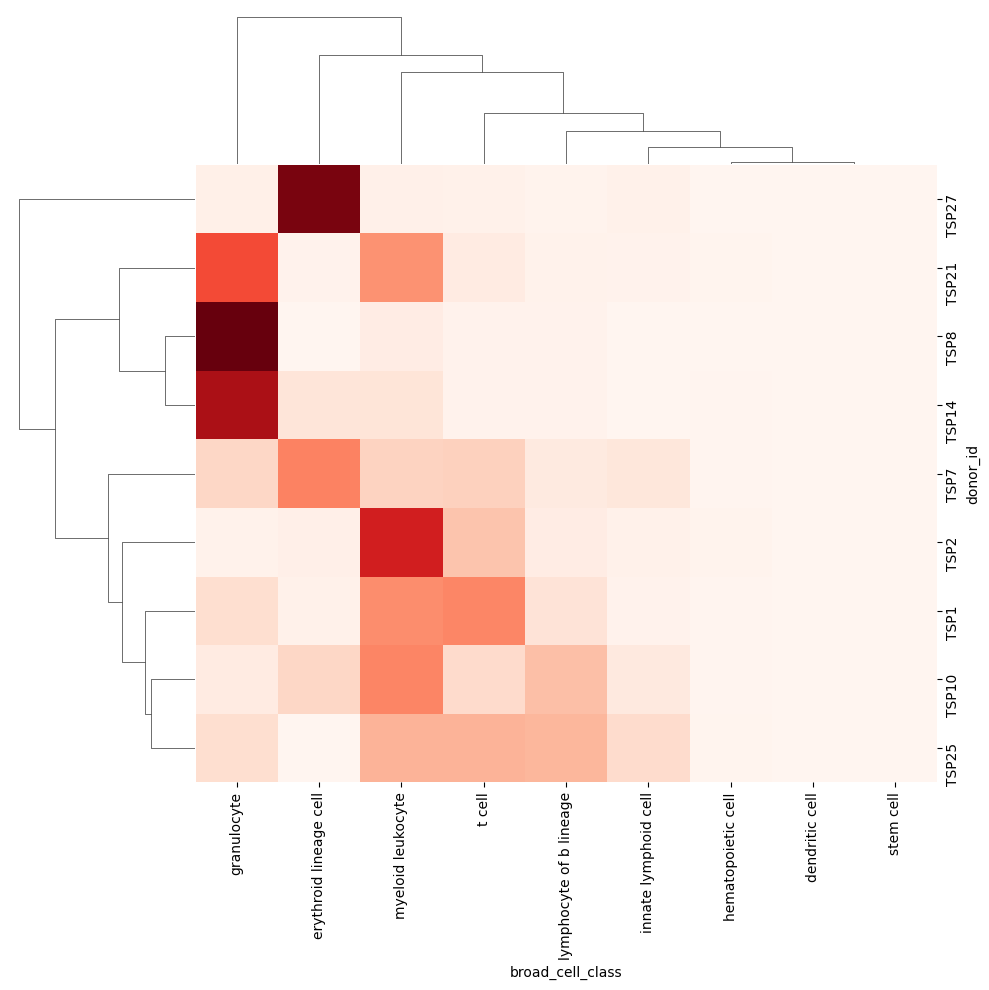

In [10]:
import seaborn as sns

counts = adata.obs.pivot_table(index="donor_id", columns="broad_cell_class", aggfunc="size")
sns.clustermap(
    counts.div(counts.sum(axis=1), axis=0),
    cmap="Reds",
    cbar_pos=None
)

# NCE-VAE Output

- Similarly, broad cell types are well defined, and we actually

/home/users/jhaberbe/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


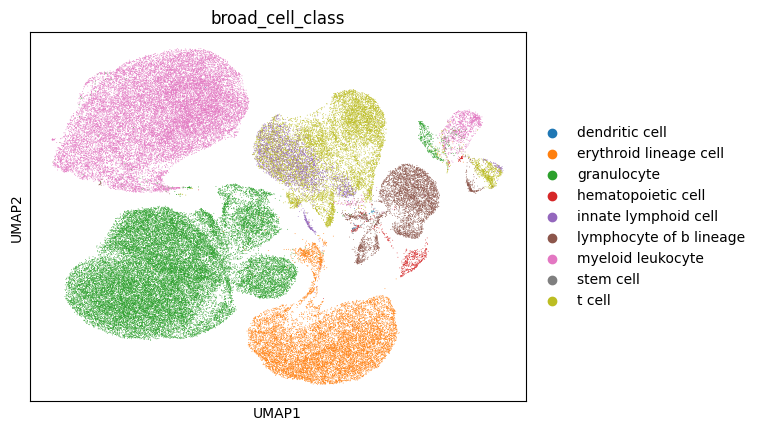

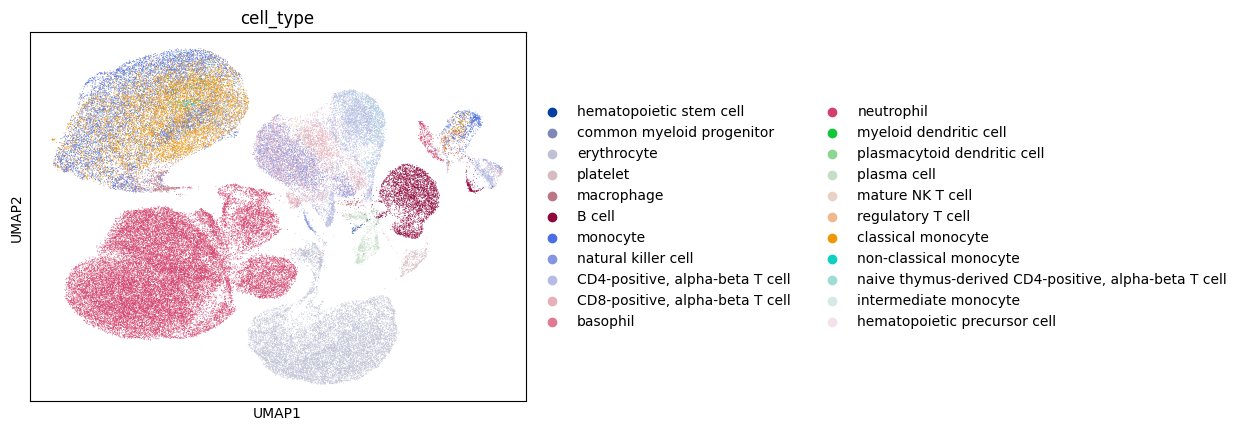

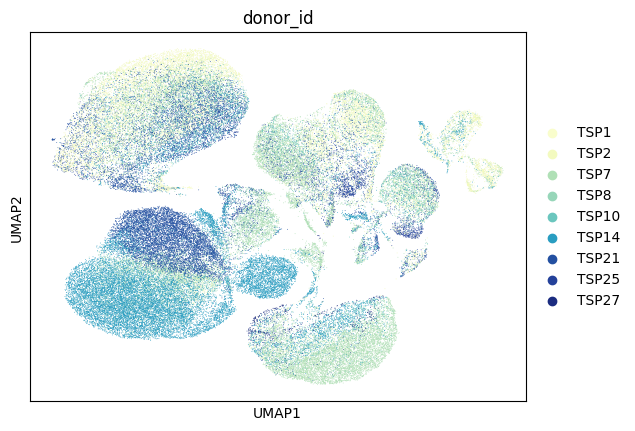

In [11]:
sc.pp.neighbors(adata, use_rep="X_ncVAE")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["broad_cell_class"])
sc.pl.umap(adata, color=["cell_type"])
sc.pl.umap(adata, color=["donor_id"])

# Clustering

As a note, the leiden resolution parameter chosen tends to be lower for NCE-VAE than typical of scVI or PCA. 0.05 here seemed to do the best at distinguishing broad classes.

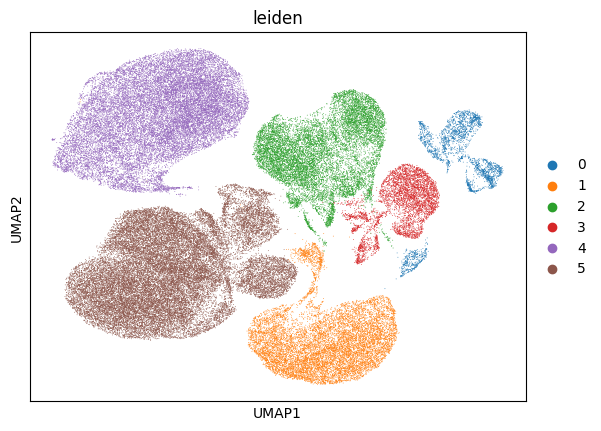

In [31]:
sc.tl.leiden(adata, resolution=.04, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

/tmp/ipykernel_105343/3256066708.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts = adata.obs.pivot_table(index="donor_id", columns="leiden", aggfunc="size")


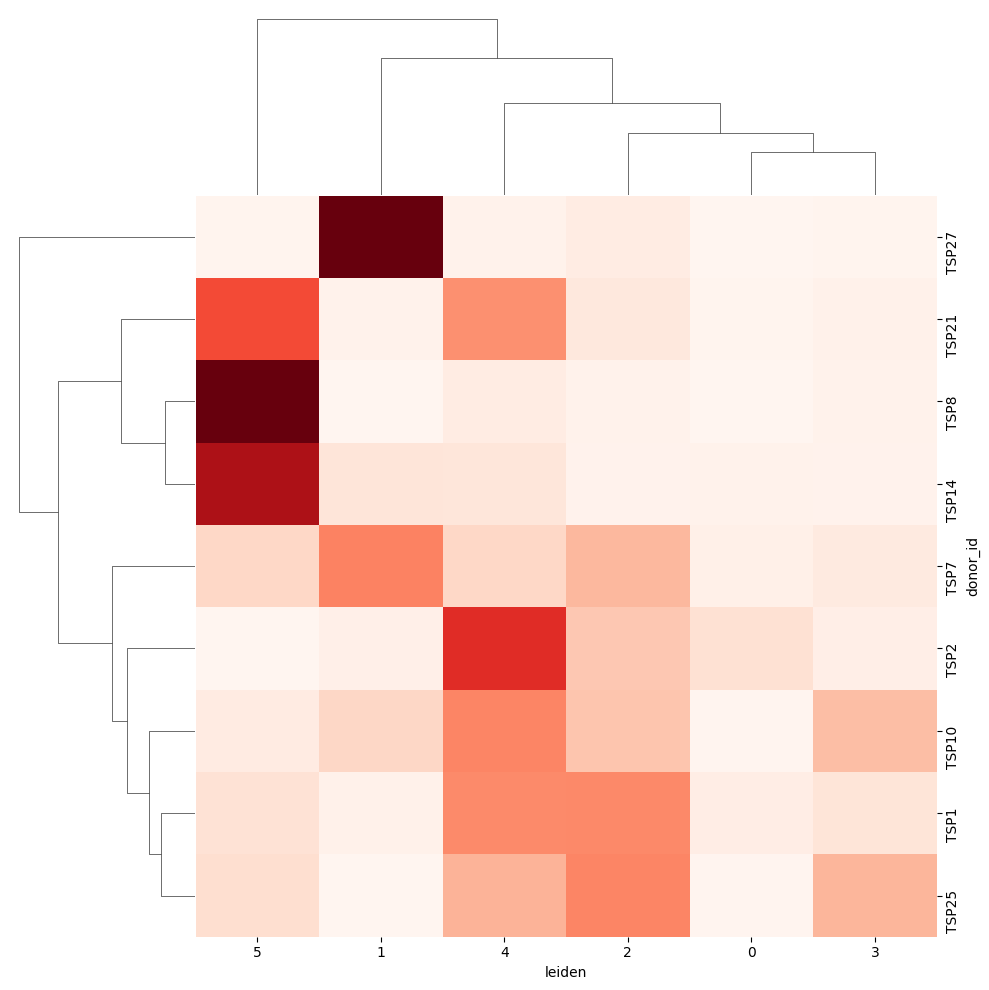

In [32]:
import seaborn as sns

counts = adata.obs.pivot_table(index="donor_id", columns="leiden", aggfunc="size")
sns.clustermap(
    counts.div(counts.sum(axis=1), axis=0),
    cmap="Reds",
    cbar_pos=None
)

# Estimation of value between two methods.

This is a pretty quick and dirty way to compare if batch effects differ. MI should be low, since we want cell types to (generally) not inform us about which sample it is collected from. We find slightly higher MI in the NCE, but they are extremely close. There is definitely room for improvement in the future.

In [33]:
import sklearn.metrics
print("Mutual Info Score between leiden clusters learned from NCE-VAE: ", sklearn.metrics.mutual_info_score(adata.obs["donor_id"], adata.obs["leiden"]))
print("Mutual Info Score between cell types learned from PCA: ", sklearn.metrics.mutual_info_score(adata.obs["donor_id"], adata.obs["broad_cell_class"]))

Mutual Info Score between leiden clusters learned from NCE-VAE:  0.3995592224989545
Mutual Info Score between cell types learned from PCA:  0.38672315744799945


Overall, I'm happy with this, and it honestly seems like if I were to train it longer, we would get even better results (though likely more batch effects would start appearing).